# Keras starter kit [full training set, UNet]

## Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from tqdm import tqdm

# Data config
DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
BUFFER = 32  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 32  # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 0  # Offset of slices in the z direction
SHARED_HEIGHT = 4000  # Height to resize all papyrii

# (x, y)
val_location = (1300, 1000)
val_zone_size = (600, 2000)

# Model config
BATCH_SIZE = 32
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

import tensorflow as tf

print(tf.__version__)



2023-05-11 02:18:20.618674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 02:18:21.117567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  4
2.12.0


2023-05-11 02:18:21.674518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-11 02:18:21.674768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-11 02:18:21.674975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

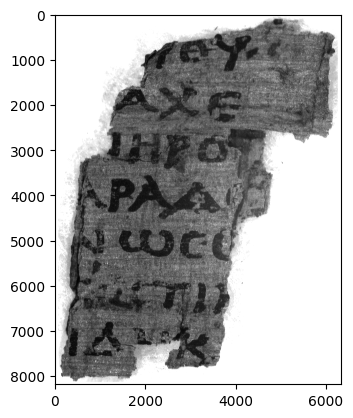

In [3]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")

## Load up the training data

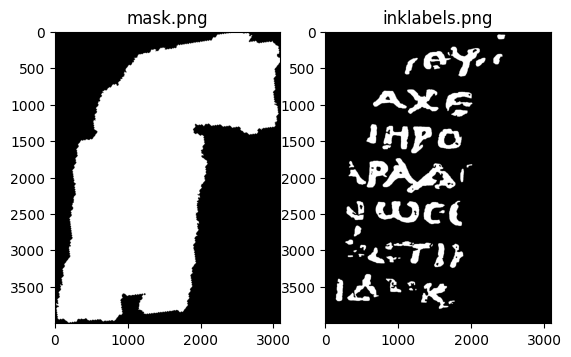

In [4]:
def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert("1")
    img = resize(img)
    return torch.tensor(np.array(img), dtype=torch.bool)


def load_labels(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png").convert("1")
    img = resize(img)
    return torch.tensor(np.array(img), dtype=torch.bool)


mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [5]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

/home/fummicc1/anaconda3/envs/ink-detection/lib/python3.11/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


mask_test_a: torch.Size([4000, 9284])
mask_test_b: torch.Size([4000, 4642])
-
mask_train_1: torch.Size([4000, 3094])
labels_train_1: torch.Size([4000, 3094])
-
mask_train_2: torch.Size([4000, 2563])
labels_train_2: torch.Size([4000, 2563])
-
mask_train_3: torch.Size([4000, 2760])
labels_train_3: torch.Size([4000, 2760])


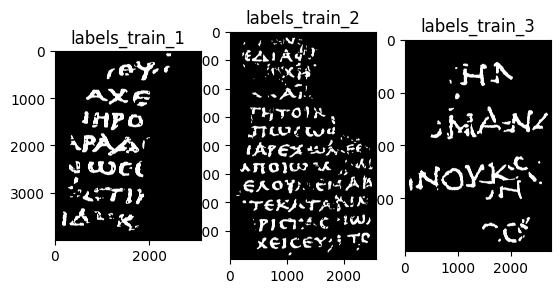

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

In [7]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename).convert("1")
        img = resize(img)
        z_slice = np.array(img, dtype=np.uint8)
        z_slices.append(z_slice)
    return np.stack(z_slices, axis=-1)

In [8]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

del volume_train_1
del volume_train_2
del volume_train_3

32it [00:05,  5.71it/s]


volume_train_1: (4000, 3094, 32), uint8


32it [00:15,  2.03it/s]


volume_train_2: (4000, 2563, 32), uint8


32it [00:04,  7.20it/s]


volume_train_3: (4000, 2760, 32), uint8
total volume: (4000, 8417, 32)


In [9]:
labels = np.concatenate([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = np.concatenate([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

labels: (4000, 8417), bool
mask: (4000, 8417), bool


## Visualize the training data

In this case, not very informative. But remember to always visualize what you're training on, as a sanity check!

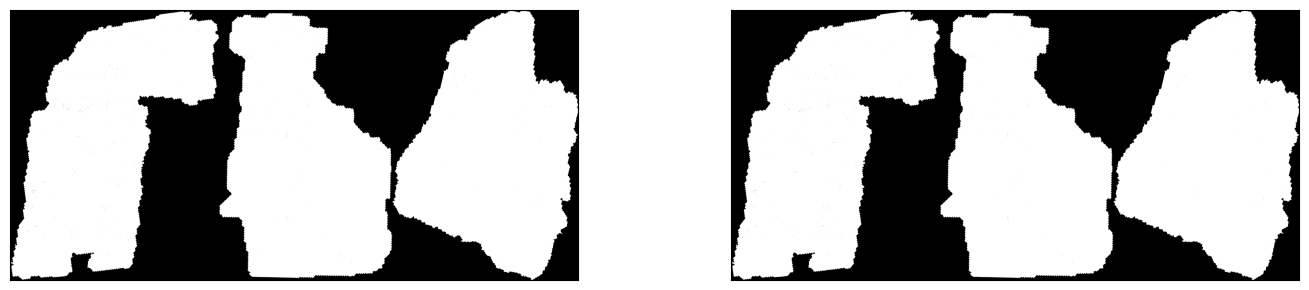

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Selection a validation holdout area

We set aside some fraction of the input to validate our model on.

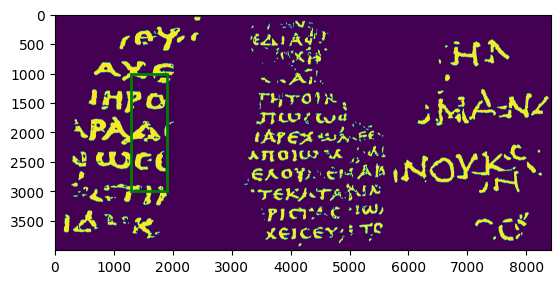

In [11]:
fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[0], val_location[1]], val_zone_size[0], val_zone_size[1], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

## Create a dataset that samples random locations in the input volume

Our training dataset will grab random patches within the masked area and outside of the validation area.

In [12]:
def sample_random_location(shape):
    random_train_x = torch.randint(low=BUFFER, high=shape[0] - BUFFER - 1, size=())
    random_train_y = torch.randint(low=BUFFER, high=shape[1] - BUFFER - 1, size=())
    random_train_location = torch.stack([random_train_x, random_train_y])
    return random_train_location


def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

# Create a list to store train locations
train_locations = []

# Define the number of train locations you want to generate
num_train_locations = 1000

# Generate train locations
while len(train_locations) < num_train_locations:
    location = sample_random_location_train(0)
    if is_proper_train_location(location):
        train_locations.append(location)

# Convert the list of train locations to a PyTorch tensor
train_locations_ds = torch.stack(train_locations)

## Visualize some training patches

Sanity check visually that our patches are where they should be.

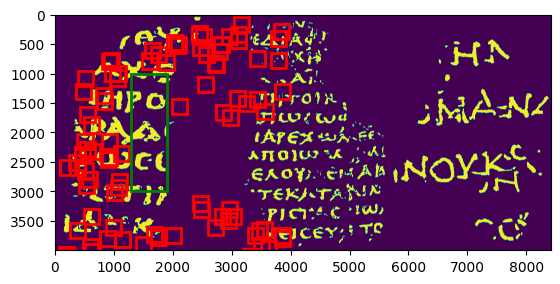

In [13]:
fig, ax = plt.subplots()
ax.imshow(labels)

# Define the number of samples you want to take from train_locations_ds
num_samples = 200

# Iterate over the first 'num_samples' elements in train_locations_ds
for i in range(num_samples):
    x, y = train_locations_ds[i]
    patch = Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[0], val_location[1]], val_zone_size[0], val_zone_size[1], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [14]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = subvolume.astype(np.float16) / 65535.
    return subvolume

## Create training dataset that yields random subvolumes and their labels

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool):
        self.locations = locations
        self.volume = volume
        self.labels = labels
        self.buffer = buffer
        self.is_train = is_train

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        location = self.locations[idx]
        x, y = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)
        # subvolume = subvolume.numpy()
        subvolume = np.transpose(subvolume, (1, 0, 2)).astype(np.float32)                
        subvolume = subvolume.copy()
        
        if self.is_train:            
            label = self.labels[x - self.buffer:x + self.buffer, y - self.buffer:y + self.buffer]        
            # label = label.numpy()
            label = np.transpose(label, (1, 0)).astype(np.uint8)
            n_category = 2
            label = np.eye(n_category)[label]
            label = label.copy().astype(np.float16)
            
            performed = A.Compose([                
                A.RandomBrightnessContrast(),
                A.RandomBrightnessContrast(),
                A.HorizontalFlip(),
                A.VerticalFlip(),  
            ])(image=subvolume, mask=label)          
            subvolume = performed["image"]
            label = performed["mask"]
            subvolume = np.transpose(subvolume, (2, 0, 1))
            label = np.transpose(label, (2, 0, 1))
            # print(performed)
            # print(subvolume.shape, label.shape)
        else:
            subvolume = np.transpose(subvolume, (2, 0, 1))
            label = None
        return subvolume, label

# Convert train_locations_ds to a PyTorch tensor
train_locations_tensor = torch.stack([x for x in train_locations_ds])

# Create an instance of the SubvolumeDataset
train_ds = SubvolumeDataset(train_locations_tensor, volume, labels, BUFFER, is_train=True)

# Create a DataLoader with the dataset
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)


In [16]:
subvolume_batch, label_batch = train_ds[1]
print(f"subvolume shape: {subvolume_batch.shape}")
print(f"label_batch shape: {label_batch.shape}")

subvolume shape: (32, 256, 256)
label_batch shape: (2, 256, 256)


## Check dataset throughput

It's always a good idea to check that your data pipeline is efficient. You don't want to be CPU-bound at training time!

In [17]:
# t0 = time.time()
# n = 200
# for _ in train_ds:
#     pass
# print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

## Create validation dataset

In [18]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

# Convert the list of val locations to a PyTorch tensor
val_locations_ds = torch.tensor(val_locations)

# Create an instance of the SubvolumeDataset
val_ds = SubvolumeDataset(val_locations_ds, volume, labels, BUFFER, is_train=True)

# Create a DataLoader with the dataset
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

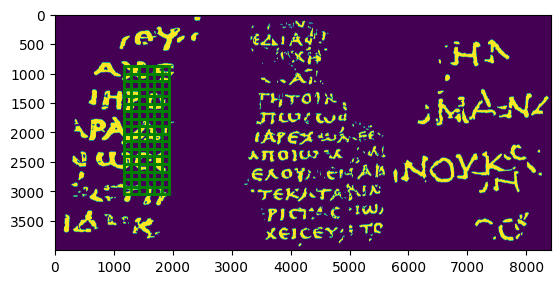

In [19]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

In [20]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        batch_label = torch.from_numpy(batch_label)
        matches += torch.sum(batch_label.float())
        total += torch.numel(batch_label)
    return 1. - matches / total

score = trivial_baseline(val_ds).item()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

100%|██████████| 80/80 [00:01<00:00, 61.92it/s]

Best validation score achievable trivially: 50.00% accuracy


## Augment the training data

## Train a Keras model

This model is a U-Net taken from [this segmentation tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

`model.fit()` goes brrrrr

Conceptually it looks like this (animation from [this tutorial](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial)):

![animation](https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

In [22]:

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
            )

        def transpose_conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
            )

        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 2 else 64 * 2**(i - 1), 64 * 2**i, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.ReLU(),
                nn.Conv2d(64 * 2**i, 64 * 2**i, kernel_size=3, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.ReLU(),
            )
            for i in range(2, 4)
        ])


        self.middle = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512),
        )
        
        self.decoder = nn.ModuleList([
            nn.Sequential(
                transpose_conv_block(2 ** (i + 7), 2 ** (i + 6)),
                transpose_conv_block(2 ** (i + 6), 2 ** (i + 5)),
                nn.Upsample(scale_factor=2, mode="nearest"),
            )
            for i in range(3, 1, -1)
        ])
        self.final_decoder = nn.Sequential(
            nn.Conv2d(128, out_channels, kernel_size=3, padding=1),
        )        

    def forward(self, x):
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)

        x = self.middle(x)
        
        # print("encoder ok", x.shape)
        for i, layer in enumerate(self.decoder):            
            # print(f"decoder will {i}: ok", x.shape)
            x = torch.cat([x, skip_connections[-i-1]], dim=1)  # Concatenate along channel dimension
            # print(f"decoder with skip connection {i}: ok", x.shape)            
            x = layer(x)            
            # print(f"decoder {i}: ok", x.shape)
        # print("decoder ok")
        x = self.final_decoder(x)
        return x

In [23]:
import os

# Define the model
model = UNet(Z_DIM, 2)
model = nn.DataParallel(model)

if os.path.exists(f"{DATA_DIR}/model.pt"):
    # model.load_state_dict(torch.load(f"{DATA_DIR}/model.pt"))
    pass

# Mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)

# Loss, optimizer, and metric
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
accuracy = Accuracy(task="binary").to(device)

In [24]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for idx, (subvolumes, labels) in tqdm(enumerate(train_dataloader), leave=False):
        subvolumes, labels = subvolumes.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
            outputs = model(subvolumes)                          
            loss = criterion(outputs, labels)                              
            outputs = nn.Softmax2d()(outputs)            
            acc = accuracy(outputs, labels)
            outputs = outputs[:, 1, :, :].unsqueeze(dim=1).float()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        running_accuracy += acc
        
    running_loss /= len(train_dataloader)
    running_accuracy /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for subvolumes, labels in tqdm(val_dataloader, leave=False):
            subvolumes, labels = subvolumes.to(device), labels.to(device)
            outputs = model(subvolumes)
            loss = criterion(outputs, labels)                              
            outputs = nn.Softmax2d()(outputs)            
            acc = accuracy(outputs, labels)
            outputs = outputs[:, 1, :, :].unsqueeze(dim=1).float()

            val_loss += loss.item()
            val_accuracy += acc

    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss:.4f} Accuracy: {running_accuracy:.4f} Val_Loss: {val_loss:.4f} Val_Accuracy: {val_accuracy:.4f}")

    running_loss = 0.0
    running_accuracy = 0.0
    model.train()

torch.save(model.state_dict(), "model.pt")

  3%|▎         | 1/30 [00:13<06:42, 13.89s/it]

Epoch [1/30] Loss: 0.7034 Accuracy: 0.5866 Val_Loss: 0.6910 Val_Accuracy: 0.3700


  7%|▋         | 2/30 [00:22<05:03, 10.82s/it]

Epoch [2/30] Loss: 0.6707 Accuracy: 0.7294 Val_Loss: 0.5931 Val_Accuracy: 0.8637


 10%|█         | 3/30 [00:31<04:26,  9.88s/it]

Epoch [3/30] Loss: 0.6542 Accuracy: 0.7417 Val_Loss: 0.6562 Val_Accuracy: 0.7138


 13%|█▎        | 4/30 [00:40<04:05,  9.45s/it]

Epoch [4/30] Loss: 0.6439 Accuracy: 0.7380 Val_Loss: 0.6765 Val_Accuracy: 0.6327


 17%|█▋        | 5/30 [00:48<03:50,  9.21s/it]

Epoch [5/30] Loss: 0.6281 Accuracy: 0.7487 Val_Loss: 0.5821 Val_Accuracy: 0.8168


 20%|██        | 6/30 [00:58<03:40,  9.17s/it]

Epoch [6/30] Loss: 0.6149 Accuracy: 0.7603 Val_Loss: 0.5751 Val_Accuracy: 0.8204


 23%|██▎       | 7/30 [01:06<03:28,  9.07s/it]

Epoch [7/30] Loss: 0.5965 Accuracy: 0.7779 Val_Loss: 0.5346 Val_Accuracy: 0.8326


 27%|██▋       | 8/30 [01:15<03:17,  8.99s/it]

Epoch [8/30] Loss: 0.5800 Accuracy: 0.7746 Val_Loss: 0.5438 Val_Accuracy: 0.8390


 30%|███       | 9/30 [01:24<03:07,  8.93s/it]

Epoch [9/30] Loss: 0.5590 Accuracy: 0.7983 Val_Loss: 0.4884 Val_Accuracy: 0.8589


 33%|███▎      | 10/30 [01:33<02:57,  8.88s/it]

Epoch [10/30] Loss: 0.5458 Accuracy: 0.7942 Val_Loss: 0.4903 Val_Accuracy: 0.8716


 37%|███▋      | 11/30 [01:42<02:48,  8.88s/it]

Epoch [11/30] Loss: 0.5223 Accuracy: 0.8213 Val_Loss: 0.5737 Val_Accuracy: 0.7374


 40%|████      | 12/30 [01:50<02:39,  8.85s/it]

Epoch [12/30] Loss: 0.5064 Accuracy: 0.8250 Val_Loss: 0.4219 Val_Accuracy: 0.8807


 43%|████▎     | 13/30 [01:59<02:30,  8.86s/it]

Epoch [13/30] Loss: 0.4861 Accuracy: 0.8381 Val_Loss: 0.4484 Val_Accuracy: 0.8802


 47%|████▋     | 14/30 [02:08<02:21,  8.83s/it]

Epoch [14/30] Loss: 0.4711 Accuracy: 0.8420 Val_Loss: 0.4043 Val_Accuracy: 0.8806


 50%|█████     | 15/30 [02:17<02:12,  8.85s/it]

Epoch [15/30] Loss: 0.4626 Accuracy: 0.8411 Val_Loss: 0.4079 Val_Accuracy: 0.8808


 53%|█████▎    | 16/30 [02:26<02:03,  8.84s/it]

Epoch [16/30] Loss: 0.4539 Accuracy: 0.8421 Val_Loss: 0.4327 Val_Accuracy: 0.8808


 57%|█████▋    | 17/30 [02:35<01:55,  8.85s/it]

Epoch [17/30] Loss: 0.4513 Accuracy: 0.8408 Val_Loss: 0.3947 Val_Accuracy: 0.8807


 60%|██████    | 18/30 [02:43<01:46,  8.85s/it]

Epoch [18/30] Loss: 0.4467 Accuracy: 0.8412 Val_Loss: 0.4397 Val_Accuracy: 0.8808


 63%|██████▎   | 19/30 [02:52<01:37,  8.85s/it]

Epoch [19/30] Loss: 0.4433 Accuracy: 0.8422 Val_Loss: 0.4258 Val_Accuracy: 0.8605


 67%|██████▋   | 20/30 [03:01<01:28,  8.84s/it]

Epoch [20/30] Loss: 0.4416 Accuracy: 0.8413 Val_Loss: 0.3736 Val_Accuracy: 0.8808


 70%|███████   | 21/30 [03:10<01:19,  8.85s/it]

Epoch [21/30] Loss: 0.4408 Accuracy: 0.8419 Val_Loss: 0.3888 Val_Accuracy: 0.8807


 73%|███████▎  | 22/30 [03:19<01:10,  8.85s/it]

Epoch [22/30] Loss: 0.4358 Accuracy: 0.8435 Val_Loss: 0.3909 Val_Accuracy: 0.8808


 77%|███████▋  | 23/30 [03:28<01:02,  8.86s/it]

Epoch [23/30] Loss: 0.4354 Accuracy: 0.8432 Val_Loss: 0.3924 Val_Accuracy: 0.8808


 80%|████████  | 24/30 [03:37<00:53,  8.84s/it]

Epoch [24/30] Loss: 0.4397 Accuracy: 0.8423 Val_Loss: 0.3821 Val_Accuracy: 0.8804


 83%|████████▎ | 25/30 [03:46<00:44,  8.90s/it]

Epoch [25/30] Loss: 0.4380 Accuracy: 0.8421 Val_Loss: 0.4012 Val_Accuracy: 0.8808


 87%|████████▋ | 26/30 [03:54<00:35,  8.88s/it]

Epoch [26/30] Loss: 0.4356 Accuracy: 0.8438 Val_Loss: 0.3698 Val_Accuracy: 0.8808


 90%|█████████ | 27/30 [04:03<00:26,  8.86s/it]

Epoch [27/30] Loss: 0.4414 Accuracy: 0.8411 Val_Loss: 0.3790 Val_Accuracy: 0.8802


 93%|█████████▎| 28/30 [04:12<00:17,  8.85s/it]

Epoch [28/30] Loss: 0.4358 Accuracy: 0.8432 Val_Loss: 0.3654 Val_Accuracy: 0.8806


 97%|█████████▋| 29/30 [04:21<00:08,  8.84s/it]

Epoch [29/30] Loss: 0.4361 Accuracy: 0.8430 Val_Loss: 0.3832 Val_Accuracy: 0.8803


100%|██████████| 30/30 [04:30<00:00,  9.01s/it]


Epoch [30/30] Loss: 0.4345 Accuracy: 0.8440 Val_Loss: 0.3952 Val_Accuracy: 0.8628


## Clear up memory

In [25]:
del volume
del mask
del labels
del train_ds
del val_ds

import gc
gc.collect()

0

In [26]:
model = UNet(Z_DIM, 2)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("model.pt"))
model = model.to(device)

## Compute predictions on test data

In [27]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = torch.from_numpy(subvolume).float() / 65535.
    return subvolume


import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

def compute_predictions_map(split, index):
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)

    test_locations = []
    stride = BUFFER // 2
    for x in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((x, y))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # filter locations inside the mask
    test_locations = [loc for loc in test_locations if is_in_masked_zone(loc, test_mask)]

    class TestDataset(Dataset):
        def __init__(self, test_locations, test_volume):
            self.test_locations = test_locations
            self.test_volume = test_volume

        def __len__(self):
            return len(self.test_locations)

        def __getitem__(self, idx):
            location = torch.tensor(self.test_locations[idx])        
            subvolume = extract_subvolume(location, self.test_volume)
            subvolume = torch.permute(subvolume, (2, 1, 0))
            return location, subvolume

    test_ds = TestDataset(test_locations, test_volume)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    predictions_map = np.zeros(test_volume.shape[:2] + (1,), dtype=np.float32)
    predictions_map_counts = np.zeros(test_volume.shape[:2] + (1,), dtype=np.float32)

    print(f"Compute predictions")

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for loc_batch, patch_batch in tqdm(test_loader):
            loc_batch = loc_batch.to(device)
            patch_batch = patch_batch.to(device)
            predictions = model(patch_batch)
            predictions = nn.Softmax2d()(predictions)
            predictions = predictions[:, 1, :, :].unsqueeze(dim=1)
            predictions = torch.permute(predictions, (0, 3, 2, 1))            
            predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
            for (x, y), pred in zip(loc_batch, predictions):
                predictions_map[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += pred
                predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map


In [28]:
from skimage.transform import resize as resize_ski
import pathlib

In [29]:
def rle(predictions_map, threshold):
    flat_img = (np.where(predictions_map.flatten() > threshold, 1, 0)).astype(np.uint8)

    starts = np.where((flat_img[:-1] == 0) & (flat_img[1:] == 1))[0] + 2
    ends = np.where((flat_img[:-1] == 1) & (flat_img[1:] == 0))[0] + 2

    lengths = ends - starts

    return " ".join(map(str, np.c_[starts, lengths].flatten()))

In [30]:
threshold = 0.85

print("Id,Predicted", file=open('submission.csv', 'w'))

def update_submission(predictions_map, index):
    rle_ = rle(predictions_map, threshold=threshold)
    print(f"{index}," + rle_, file=open('submission.csv', 'a'))

## Resize prediction maps to their original size (for submission)

In [31]:
folder = pathlib.Path(DATA_DIR) / "test"
for p in folder.iterdir():
    index = p.stem
    predictions_map = compute_predictions_map(split="test", index=index)
    original_size = Image.open(DATA_DIR + f"/test/{index}/mask.png").size
    predictions_map = resize_ski(predictions_map, (original_size[1], original_size[0])).squeeze()
    update_submission(predictions_map, index)

Load data for test/a


32it [00:02, 11.29it/s]


8378 test locations (before filtering by mask)
Compute predictions


100%|██████████| 172/172 [00:22<00:00,  7.64it/s]


Load data for test/b


32it [00:03,  8.43it/s]


4071 test locations (before filtering by mask)
Compute predictions


100%|██████████| 73/73 [00:09<00:00,  7.55it/s]
